# 1. Autoencoder

In [1]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import models
from keras import backend as K
from keras import layers
from keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
from keras.datasets import fashion_mnist


Using TensorFlow backend.


In [4]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [2]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

4423680/4422102 [==============================] - 3s 1us/step


In [5]:
from keras.callbacks import TensorBoard
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 64s 1ms/step - loss: 0.3735 - val_loss: 0.3342
Epoch 2/50
 1024/60000 [..............................] - ETA: 1:02 - loss: 0.3347

KeyboardInterrupt: 

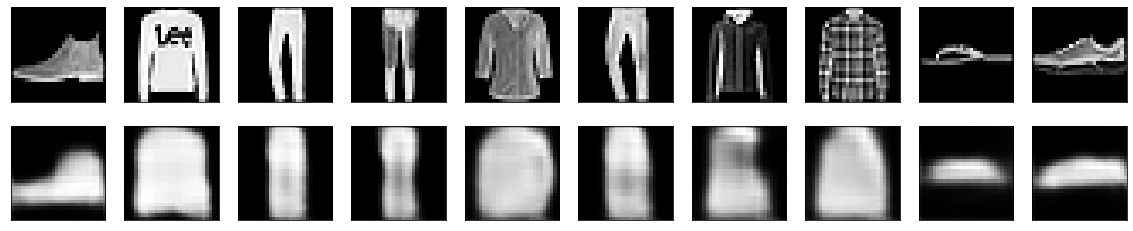

In [7]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 2. Image Classification

## 2.1 Deep CNN

In [8]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
#preparing the data for training
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#create sequential
model = models.Sequential()
#add layers
model.add(layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(layers.Conv2D(32, kernel_size=3, activation='relu'))
model.add(layers.Conv2D(16, kernel_size=3, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 124s 2ms/step - loss: 0.5004 - accuracy: 0.8374 - val_loss: 0.3820 - val_accuracy: 0.8635
Epoch 2/3
60000/60000 [==============================] - 118s 2ms/step - loss: 0.3200 - accuracy: 0.8855 - val_loss: 0.3996 - val_accuracy: 0.8615
Epoch 3/3
60000/60000 [==============================] - 123s 2ms/step - loss: 0.2803 - accuracy: 0.8979 - val_loss: 0.3297 - val_accuracy: 0.8839


In [9]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 245us/step


[0.32965097715854647, 0.883899986743927]

## 2.2 Transfer Learning

In [10]:
from keras.datasets import mnist
from keras.preprocessing.image import img_to_array, array_to_img
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
#resizing the images to fit min size of resnet
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)
X_train = np.concatenate([X_train]*3, axis = -1)
X_test = np.concatenate([X_test]*3, axis = -1)
X_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32, 32)))for im in X_train])
X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32, 32)))for im in X_test])
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape)

(60000, 32, 32, 3)


In [11]:
#calling the resnet model
keras_layer = keras.applications.resnet.ResNet50(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=(32,32,3), pooling=None, classes=10
)
res_Model = models.Sequential()
res_Model.add(keras_layer)
res_Model.add(layers.Flatten())
res_Model.add(layers.Dense(10, activation='softmax'))
res_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train the model
res_Model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
15136/60000 [======>.......................] - ETA: 32:54 - loss: 0.8395 - accuracy: 0.7656

KeyboardInterrupt: 

In [12]:
res_Model.evaluate(X_test, y_test)

10000/10000 [==============================] - 36s 4ms/step


[0.599646451997757, 0.77920001745224]

# 3. Text Classification

## 3.1 RNN

In [ ]:
from keras.preprocessing.text import Tokenizer

In [42]:
df = pd.read_csv('twitter-data/tweets_with_labels.csv', sep='\t')
print(df.head())

   id                                              tweet   k1   k2   k3   k4  \
0   1                Jazz for a Rainy Afternoon:  {link}  0.0  0.0  0.0  0.0   
1   2                   RT: @mention: I love rainy days.  0.0  0.0  0.0  0.0   
2   3  Good Morning Chicago! Time to kick the Windy C...  0.0  0.0  0.0  0.0   
3   6  Preach lol! :) RT @mention: #alliwantis this t...  0.0  0.0  0.0  0.0   
4   9                     @mention good morning sunshine  0.0  0.0  0.0  0.0   

    k5   k6     k7   k8     k9  k10  k11  k12    k13  k14  k15  
0  0.0  0.0  0.000  0.0  0.000  1.0  0.0  0.0  0.000  0.0  0.0  
1  0.0  0.0  0.000  0.0  0.000  1.0  0.0  0.0  0.000  0.0  0.0  
2  0.0  0.0  1.000  0.0  0.000  0.0  0.0  0.0  0.000  0.0  0.0  
3  0.0  0.0  0.604  0.0  0.196  0.0  0.0  0.0  0.201  0.0  0.0  
4  0.0  0.0  0.000  0.0  0.000  0.0  0.0  0.0  1.000  0.0  0.0  


In [43]:
X=df['tweet']
y=df.iloc[:, 2:17]
print(X.head())
print(y.head())

0                  Jazz for a Rainy Afternoon:  {link}
1                     RT: @mention: I love rainy days.
2    Good Morning Chicago! Time to kick the Windy C...
3    Preach lol! :) RT @mention: #alliwantis this t...
4                       @mention good morning sunshine
Name: tweet, dtype: object
    k1   k2   k3   k4   k5   k6     k7   k8     k9  k10  k11  k12    k13  k14  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.000  1.0  0.0  0.0  0.000  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.000  1.0  0.0  0.0  0.000  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  1.000  0.0  0.000  0.0  0.0  0.0  0.000  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.604  0.0  0.196  0.0  0.0  0.0  0.201  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.000  0.0  0.0  0.0  1.000  0.0   

   k15  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  


In [44]:
#divid x by space
length = X.size
val =[]
for i in range(length):
    val.append(X[i].split())
X.update(pd.Series(val))
print(X.head())

0            [Jazz, for, a, Rainy, Afternoon:, {link}]
1              [RT:, @mention:, I, love, rainy, days.]
2    [Good, Morning, Chicago!, Time, to, kick, the,...
3    [Preach, lol!, :), RT, @mention:, #alliwantis,...
4                  [@mention, good, morning, sunshine]
Name: tweet, dtype: object


In [ ]:
#divid x into words/tokens using keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
def max_len(s):
    max_l = 0
    for c in s:
        if max_l<len(c):
            max_l=len(c)
    return max_l